<a href="https://colab.research.google.com/github/MehrdadDastouri/mnist_cnn/blob/main/mnist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 56.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.05MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 13.5MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.88MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



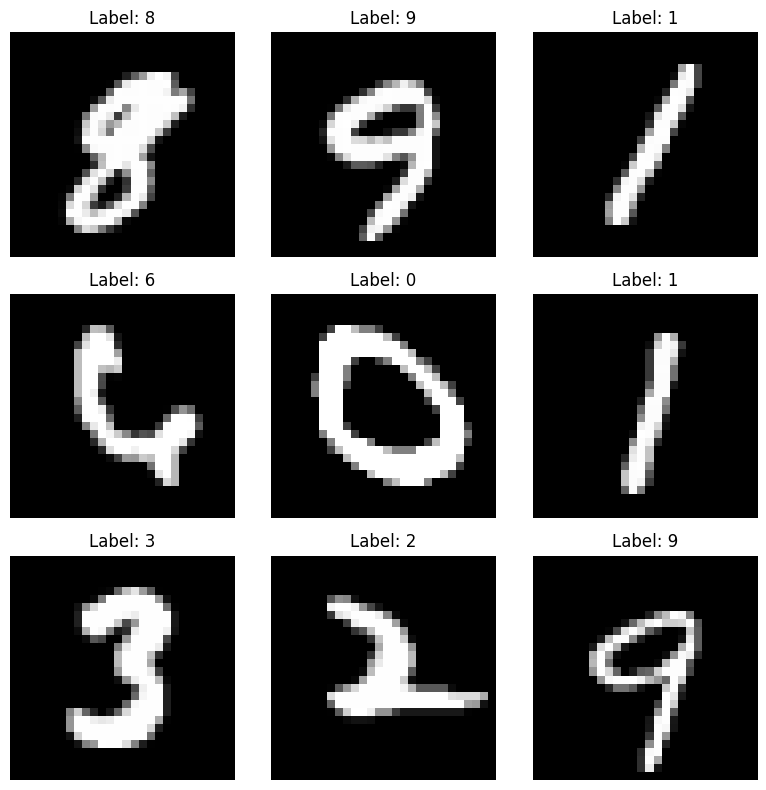

Epoch [1/5], Loss: 0.1890
Epoch [2/5], Loss: 0.0538
Epoch [3/5], Loss: 0.0389
Epoch [4/5], Loss: 0.0293
Epoch [5/5], Loss: 0.0229


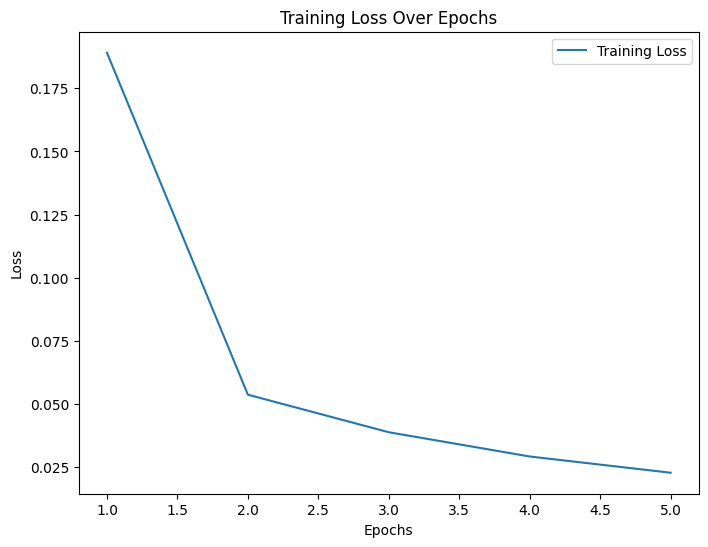

Test Accuracy: 98.80%


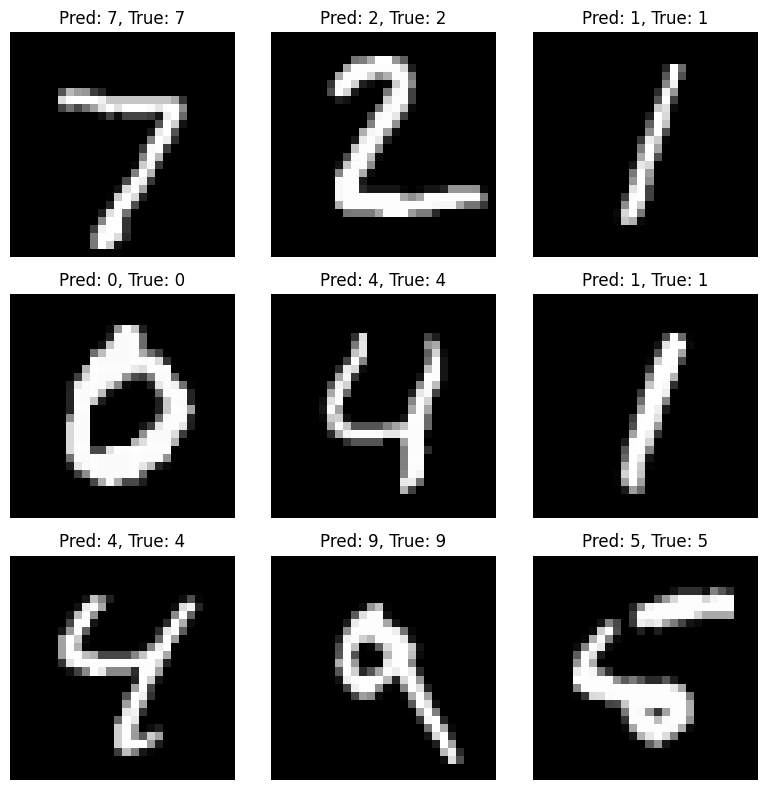

In [1]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 5

# Data preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Visualize some training data
examples = iter(train_loader)
example_data, example_targets = next(examples)

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(example_data[i][0], cmap="gray")
    plt.title(f"Label: {example_targets[i].item()}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # Conv layer 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # Conv layer 2
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # Fully connected layer 1
        self.fc2 = nn.Linear(128, 10)  # Fully connected layer 2 (output layer)
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer
        self.relu = nn.ReLU()  # ReLU activation

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        x = x.view(-1, 32 * 7 * 7)  # Flatten
        x = self.relu(self.fc1(x))  # Fully connected 1 -> ReLU
        x = self.fc2(x)  # Fully connected 2 (output layer)
        return x

# Initialize the model
model = CNN().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross Entropy Loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
train_losses = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(epoch_loss / len(train_loader))
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Visualize some test predictions
examples = iter(test_loader)
example_data, example_targets = next(examples)
example_data, example_targets = example_data.to(device), example_targets.to(device)
with torch.no_grad():
    predictions = model(example_data)
    _, preds = torch.max(predictions, 1)

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(example_data[i][0].cpu(), cmap="gray")
    plt.title(f"Pred: {preds[i].item()}, True: {example_targets[i].item()}")
    plt.axis("off")
plt.tight_layout()
plt.show()